<a href="https://colab.research.google.com/github/MadhurimaPaul-87/Research_Plan_Makaut/blob/main/Chapter_2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 51.7 MB/s eta 0:00:00


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 33.5 MB/s eta 0:00:00


In [39]:
import numpy as np
import mne
from scipy.signal import detrend
from sklearn.decomposition import FastICA
from pywt import wavedec, waverec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
#wavelets like 'sym' or 'coif' /5
def wavelet_denoise(signal, wavelet='db4', level=5, threshold_func=np.median):
    coeffs = wavedec(signal, wavelet, level=level)
    sigma = threshold_func(np.abs(coeffs[-1])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [np.where(np.abs(c) > uthresh, c, 0) for c in coeffs[1:]]
    return waverec(coeffs, wavelet)

def apply_ica(eeg_data, n_components=None):
    ica = FastICA(n_components=n_components, random_state=42)
    sources = ica.fit_transform(eeg_data.T).T
    reconstructed = ica.inverse_transform(sources.T).T
    return reconstructed

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder

def adaptive_baseline_correction(eeg_data):
    corrected = np.array([detrend(ch, type='constant') for ch in eeg_data])
    return corrected

def preprocess_pipeline(eeg_data, wavelet='db4', level=5, autoencoder_epochs=50, batch_size=32):
    wavelet_cleaned = np.array([wavelet_denoise(ch, wavelet, level) for ch in eeg_data])
    ica_cleaned = apply_ica(wavelet_cleaned)
    baseline_corrected = adaptive_baseline_correction(ica_cleaned)

    autoencoder = build_autoencoder(input_dim=baseline_corrected.shape[1])
    autoencoder.fit(baseline_corrected, baseline_corrected, epochs=autoencoder_epochs, batch_size=batch_size, verbose=0)
    final_cleaned = autoencoder.predict(baseline_corrected)

    return final_cleaned

def benchmark_pipeline(dataset_loader):
    results = []
    for dataset_name, loader_func in dataset_loader.items():
        raw = loader_func()
        raw.pick_types(eeg=True)
        raw_data = raw.get_data()
        cleaned_data = preprocess_pipeline(raw_data)
        results.append((dataset_name, cleaned_data))
    return results

# **Using EEGBCI dataset**

Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


<ipython-input-10-755c38b24ca4>:7: FutureWarning: The ``subject`` parameter is deprecated and will be removed in version 1.9. Use the ``subjects`` parameter (note the `s`) to suppress this warning.
  eegbci.load_data(subject=1, runs=[1])


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 13s (1.2 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


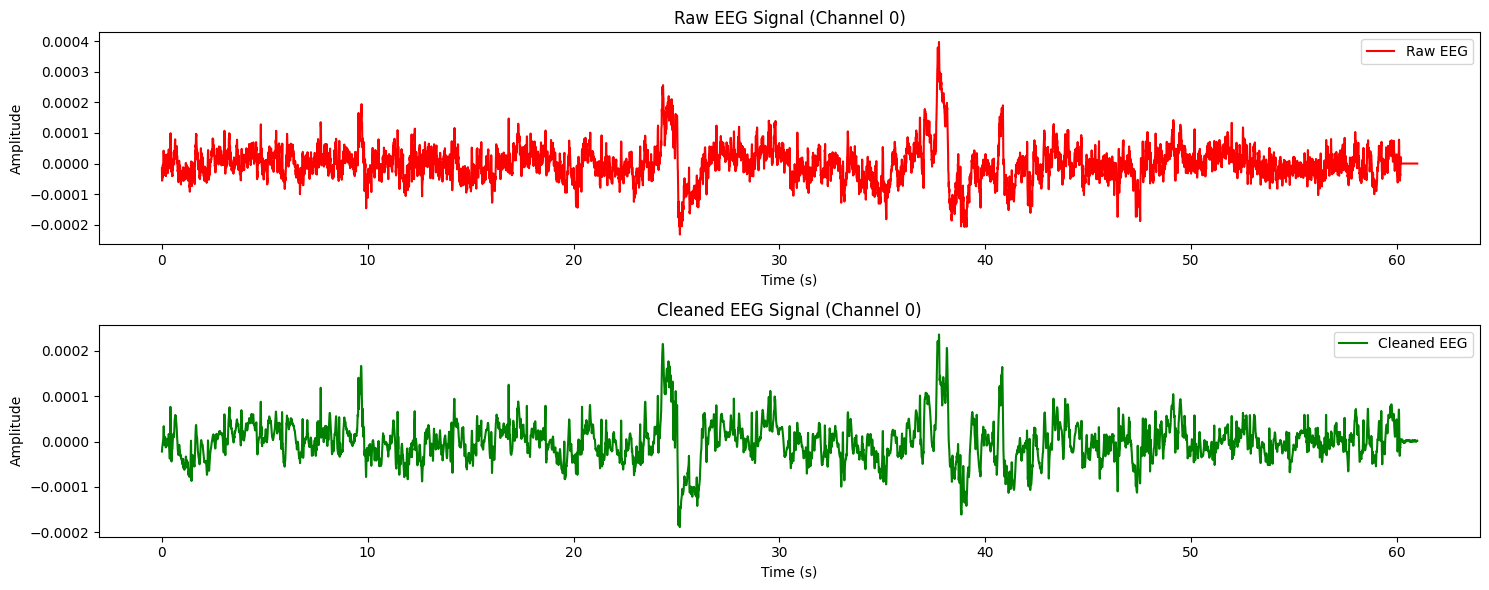

In [ ]:
import matplotlib.pyplot as plt
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

# Load DenoiseNet sample EEG dataset (using EEGBCI for demonstration)
def load_sample_eeg():
    eegbci.load_data(subject=1, runs=[1])
    raw_fnames = eegbci.load_data(1, runs=[1])
    raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    return raw

# Load sample EEG data
raw = load_sample_eeg()
raw.pick_types(eeg=True)
data, times = raw.get_data(return_times=True)

# Select one channel for visualization
channel_index = 0
raw_signal = data[channel_index]

# Clean using the defined pipeline
cleaned_signal = preprocess_pipeline(data)[channel_index]

# Plotting
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(times, raw_signal, label='Raw EEG', color='red')
plt.title("Raw EEG Signal (Channel {})".format(channel_index))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times[:len(cleaned_signal)], cleaned_signal, label='Cleaned EEG', color='green')
plt.title("Cleaned EEG Signal (Channel {})".format(channel_index))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

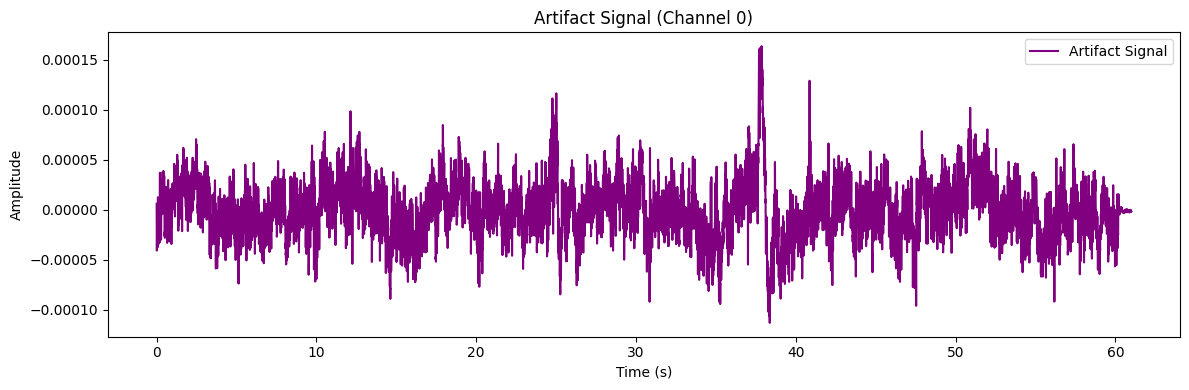

In [ ]:
# Artifact signal = Raw EEG - Cleaned EEG
artifact_signal = raw_signal[:len(cleaned_signal)] - cleaned_signal

# Plotting the artifact signal
plt.figure(figsize=(12, 4))
plt.plot(times[:len(artifact_signal)], artifact_signal, label='Artifact Signal', color='purple')
plt.title("Artifact Signal (Channel {})".format(channel_index))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def compute_snr(clean_signal, artifact_signal):
    signal_power = np.mean(clean_signal ** 2)
    noise_power = np.mean(artifact_signal ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

snr_value = compute_snr(cleaned_signal, artifact_signal)
print(snr_value)

3.7827349717856507


# **Using DenoiseNet Dataset**

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


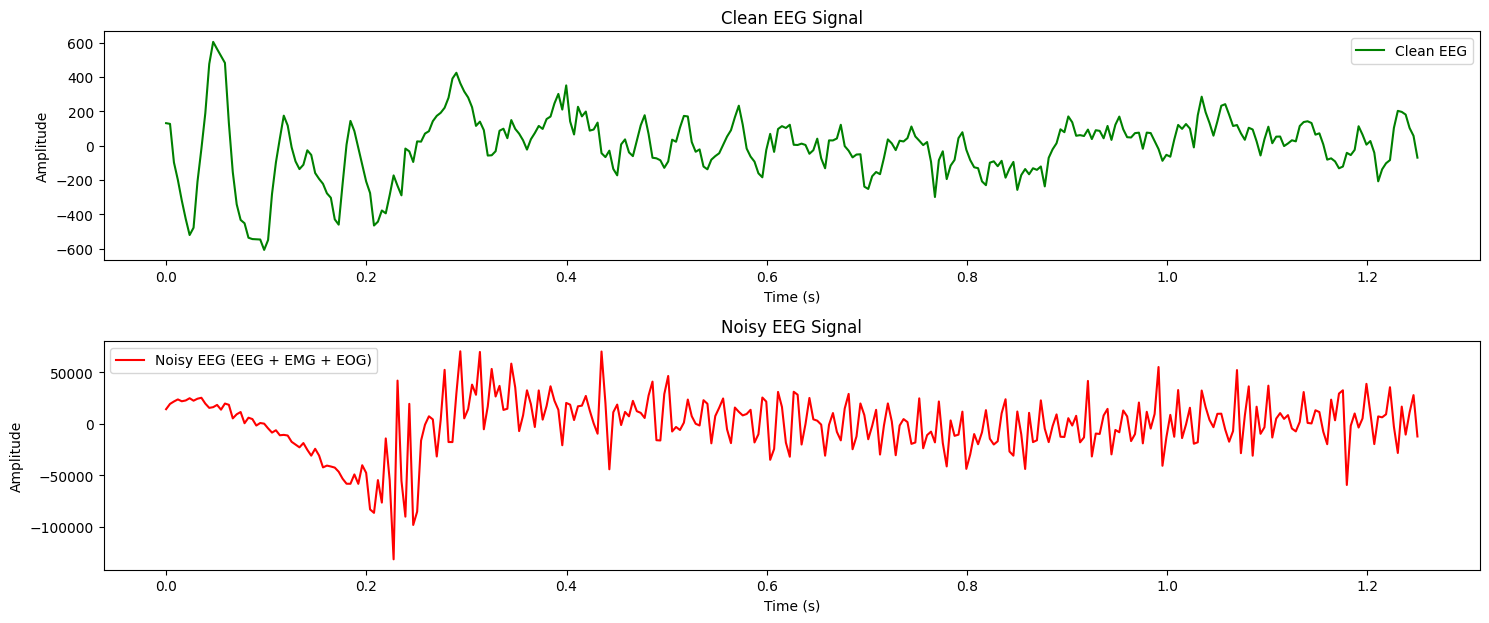

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load DenoiseNet EEG, EMG, EOG signals
eeg = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eeg_3400.npy')  # Clean EEG
emg = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/emg_3400.npy')  # EMG artifact
eog = np.load('/content/drive/MyDrive/Research_Plan/DenoiseNet(3400)/eog_3400.npy')  # EOG artifact

# Create noisy EEG signal by adding EMG and EOG
noisy_eeg = eeg + emg + eog

# Preprocess with the defined pipeline
cleaned_eeg = preprocess_pipeline(noisy_eeg)

# Select a single channel for visualization
ch = 0
length = cleaned_eeg.shape[1]
t = np.linspace(0, length / 256, length)  # Assuming 256Hz sampling rate

# Plot raw vs noisy vs cleaned EEG
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.plot(t, eeg[ch, :length], label='Clean EEG', color='green')
plt.title("Clean EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, noisy_eeg[ch, :length], label='Noisy EEG (EEG + EMG + EOG)', color='red')
plt.title("Noisy EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# plt.subplot(3, 1, 3)
# plt.plot(t, cleaned_eeg[ch], label='Denoised EEG', color='blue')
# plt.title("Denoised EEG Signal")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.legend()

plt.tight_layout()
plt.show()


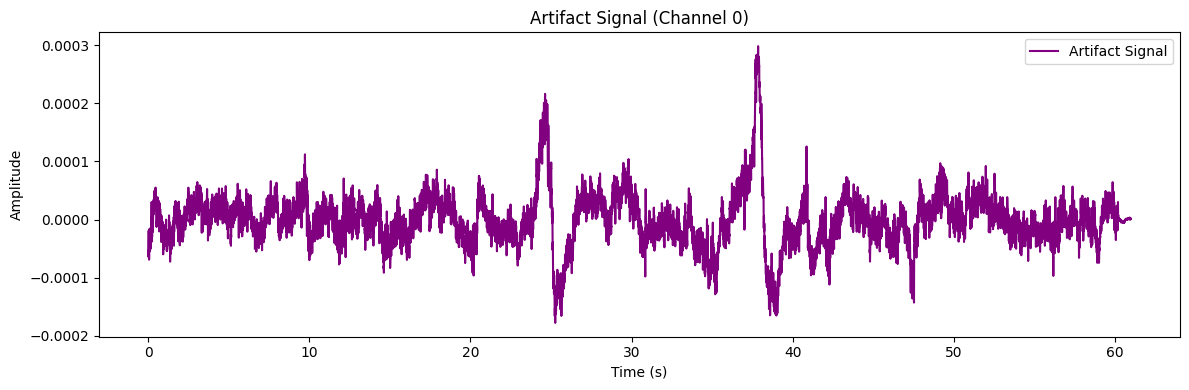

In [48]:
# Artifact signal = Raw EEG - Cleaned EEG
artifact_signal = raw_signal[:len(cleaned_signal)] - cleaned_signal

# Plotting the artifact signal
plt.figure(figsize=(12, 4))
plt.plot(times[:len(artifact_signal)], artifact_signal, label='Artifact Signal', color='purple')
plt.title("Artifact Signal (Channel {})".format(channel_index))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()